# Machine Learning Engineer Nanodegree
## Capstone
## Project: Air pressure system failures in Scania trucks

Hajime Kawata  
February 26st, 2019

Predict failure of heavy duty trucks out of sensors data

### Domain Background

Reducing the failure rate of trucks in logictics is an important issue for improving profitability and customer satisfaction in logistics business.
Until now, logistics companies rely on regular maintenance to prevent the occurrence of failures.
However, since the utilization rate of trucks exceeds the days what has been assumed to be covered by periodic maintenance, the percentage of post-maintenance caused by failures increasing, which has been a problem for some time.

For this reason, it is strongly required that inspection and maintenance work be performed before regular failure, by appropriately detecting signs of failure during regular maintenance
In order to properly capture signs of failure, it has been considered to use data collected from sensors installed in trucks, bu sensor data is gathered in milliseconds at longest, and collection targets are also diverse.
As a result, several hundred megabytes of data may be generated from one track on a day.
A large data cost has been anticipated.

In this project in order to quickly and flexibly arrange trucks based on failure prediction,
- Reduce the amount of features derived from the target sensor to be collected and suppress the arithmetic cost to be generated
- Perform a failure based on the logic derived from the data pattern leading to the failure on the truck side.

This would make it possible to appropriately send alerts before the actual failure occurrence to the monitoring center and to adjust the arrangement of the trucks.


### Problem Statement

Here, using the training data, we derive the prediction model of the occurrence of the failure (label) from the sensor data (features). This prediction logic is applied to the test data and the ability of the prediction logic is evaluated.
The sensor data is anonymized for confidentiality reasons, and so we have to make the prediction model purely on mathematical and statistical approach.

### Project Design

1. Split the training data set to establish model and evaluate
1. Apply PCA to reduce the dimension of the model.
1. Device predictor with XGBoost classifier, while seeking the best hyperparameter values with Grid Search by ROC-AUC.
1. Evaluate with the model with given test set, with confusion matrix, and accuracy, precision, and f1 scores.
1. Using the given test set to evaluate the model
1. Evaluate the contribution of feature, to discuss the possibility of reducing the sensors to predict failures.


## Libraries Used (Imports)

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display # Allows the use of display() for DataFrames

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.scorer import make_scorer, accuracy_score, recall_score, roc_auc_score, r2_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


import xgboost as xgb
from xgboost import plot_tree
from xgboost import plot_importance

# Pretty display for notebooks
%matplotlib inline

random_seed = 42

## Data Exploration

In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

このデータ・セットにおいて訓練データとテストデータは所与のものとして指定されているので、これらを用いる。
センサーデータは8bit単位でセンサーから取得される（参照　I2CやSPIなどの電子回路では１byte(=8bit)データとして取得できる）。これについては、実際の物理的な計測値に変換された下記データを用いるものとする。
    train = pd.read_csv('data/aps_failure_training_set_processed_8bit.csv')
    test = pd.read_csv('data/aps_failure_test_set_processed_8bit.csv')

### Datasets and Inputs

Data is provided in :
*Kaggle* : https://www.kaggle.com/uciml/aps-failure-at-scania-trucks-data-set/home

*The dataset consists of data collected from heavy Scania trucks in everyday usage. The system in focus is the Air Pressure system (APS) which generates pressurized air that is utilized in various functions in a truck, such as braking and gear changes.* (*Kaggle*)

| Category | Description |
|----------|-------------|
| positive class | *consists of component failures for a specific component of the APS system.* |
| negative class | *consists of trucks with failures for components not related to the APS.*  | 


Following is the data volume information.

| _ | Total | Positive | Negative | features |
|-|-|-|-|-|
| Train | 60000 | 1000 | 59000 | 171 |
| Test  | 16000 |  -    | -     | 171 |

In [2]:
# Load the trianing/Test dataset
try:
    train = pd.read_csv('data/aps_failure_training_set_processed_8bit.csv')
    test = pd.read_csv('data/aps_failure_test_set_processed_8bit.csv')
except:
    print("Dataset could not be loaded. Is the dataset missing?")

In [3]:
# Display a description of the dataset
display(train.shape)
display(test.shape)

(60000, 171)

(16000, 171)

class列で。。。
positive class 0.992188 	
negative class -0.992188


In [4]:
train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,-0.992188,0.117188,-0.289062,0.992188,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,0.687500,0.515625,0.234375,0.070312,0.007812,-0.109375,-0.140625,-0.171875,-0.023438,-0.023438
1,-0.992188,-0.179688,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,-0.023438,-0.062500,-0.132812,-0.132812,-0.187500,-0.148438,-0.085938,-0.140625,-0.023438,-0.023438
2,-0.992188,-0.125000,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,-0.140625,-0.093750,-0.015625,0.015625,-0.007812,-0.109375,-0.093750,-0.164062,-0.023438,-0.023438
3,-0.992188,-0.406250,-0.289062,-0.468750,-0.007812,-0.046875,-0.007812,-0.007812,-0.03125,-0.054688,...,-0.382812,-0.382812,-0.375000,-0.351562,-0.312500,-0.195312,-0.304688,-0.171875,0.890625,0.992188
4,-0.992188,0.007812,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,0.156250,0.031250,-0.031250,-0.039062,-0.046875,-0.015625,0.656250,-0.148438,-0.023438,-0.023438


MinとMaxは特徴量ごとに異なっている。、各パラメータは同列に評価せずに調整してから評価したほうがよい。

偏りのある特徴量がある。これは、一部の値の近辺にデータの値が集中している場合、こうした偏りのあるデータ (skewed data)を扱う場合、分類精度 (Classification Accuracy)は信用できる検証指標ではないため、F値 (F score)を採用して評価する。

分散が極端に少ないデータ、多いデータがあり、

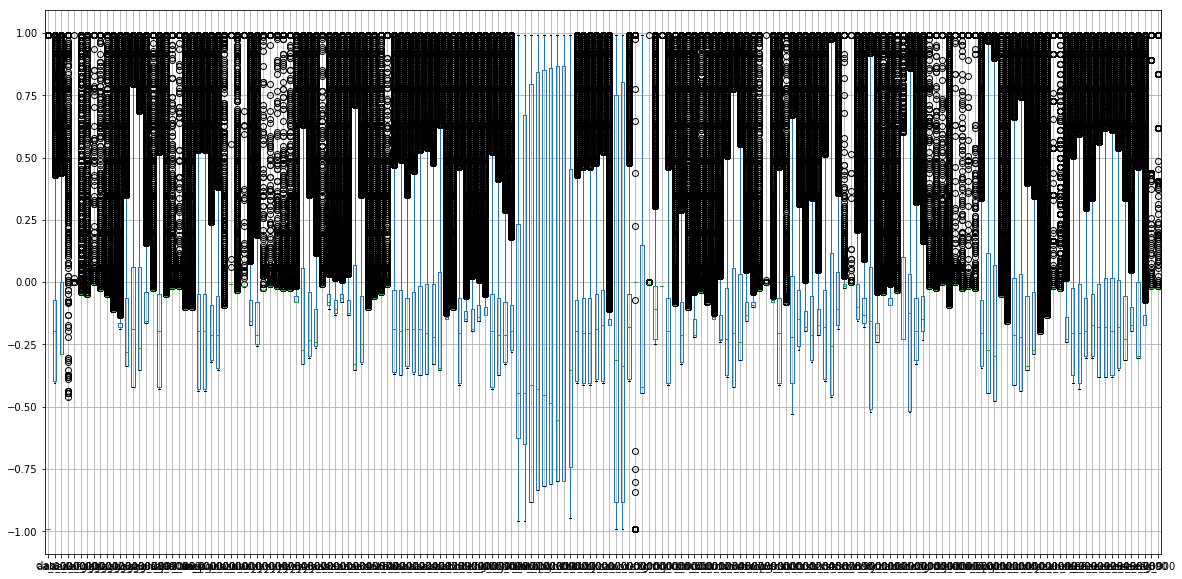

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
train.boxplot(ax=ax)
plt.show()

In [6]:
train.describe()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,-0.959115,-0.124611,-0.071121,-0.198529,-0.007737,-0.033483,-0.040633,-0.006584,-0.026241,-0.040699,...,-0.104808,-0.098734,-0.094976,-0.089227,-0.103374,-0.088961,-0.084540,-0.067471,-0.020035,-0.018417
std,0.254040,0.367680,0.356812,0.564872,0.004138,0.107086,0.111752,0.032016,0.065200,0.105864,...,0.356547,0.362066,0.363148,0.336121,0.320314,0.237613,0.363893,0.261009,0.051907,0.061751
min,-0.992188,-0.406250,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.031250,-0.054688,...,-0.382812,-0.382812,-0.382812,-0.351562,-0.312500,-0.195312,-0.304688,-0.171875,-0.023438,-0.023438
25%,-0.992188,-0.398438,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.031250,-0.054688,...,-0.382812,-0.382812,-0.375000,-0.343750,-0.312500,-0.195312,-0.304688,-0.171875,-0.023438,-0.023438
50%,-0.992188,-0.195312,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.031250,-0.054688,...,-0.179688,-0.179688,-0.195312,-0.179688,-0.226562,-0.171875,-0.296875,-0.171875,-0.023438,-0.023438
75%,-0.992188,-0.070312,-0.000000,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.031250,-0.054688,...,-0.007812,0.015625,0.015625,0.007812,-0.054688,-0.101562,-0.000000,-0.132812,-0.023438,-0.023438
max,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,...,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188


In [7]:
train['class'] = train['class'].apply(lambda x: 0 if x<=0 else 1)
test['class'] = test['class'].apply(lambda x: 0 if x<=0 else 1)

X = train.drop('class', axis=1)
y = train['class']

# use the given test set, instead of creating from the training samples
X_test_given = test.drop('class', axis=1)
y_test_given = test['class']

The column data range varies by sensors

In [8]:
y_test_given.value_counts()

0    15625
1      375
Name: class, dtype: int64

### Solution Statement

For the criteria listed in **Domain Background***,
take the following solution approach in this project

- Reduce sensor data features from 171 by PCA (Primary Components Analysis)
- Construct the model from reduced features with XGBoost classifier, by adjusting hyperparameters with Grid Search CV 

In [9]:
scaler = MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)

In [10]:
pca = PCA(0.98)
pca.fit(X_scaled)
pca.n_components_
X_reduced_data = pca.transform(X_scaled)
X_reduced_data.shape

(60000, 77)

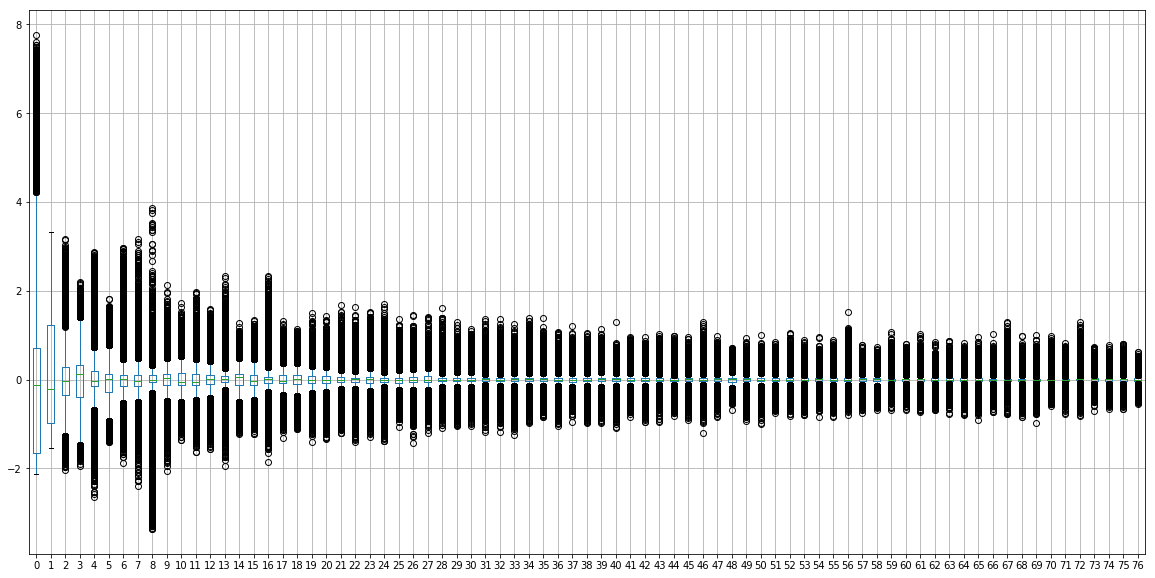

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
pd.DataFrame(X_reduced_data).boxplot(ax=ax)
plt.show()

In [12]:
X_test_given_scaled = scaler.transform(X_test_given)
X_reduced_test_data = pca.transform(X_test_given_scaled)
X_reduced_test_data.shape

(16000, 77)

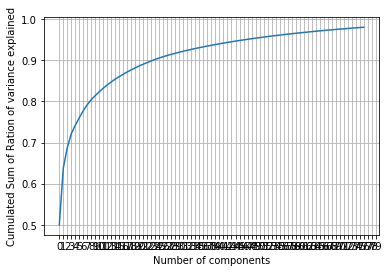

In [13]:
plt.xlabel("Number of components")
plt.ylabel("Cumulated Sum of Ration of variance explained")
plt.xticks(range(0,87))
plt.grid(True)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

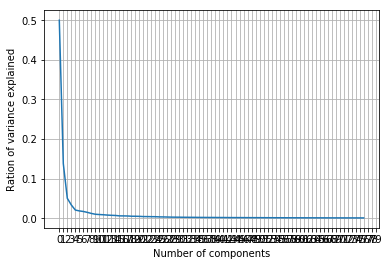

In [14]:
plt.xlabel("Number of components")
plt.ylabel("Ration of variance explained")
plt.xticks(range(0,87))
plt.grid(True)
plt.plot(pca.explained_variance_ratio_)
plt.show()

### Benchmark Model

As benchmark, adopts 60% correct answer rate.
This is based on a hearing from an interview myself conducted that the failure rate prevented by regular maintenance is about 60% by experience.
It is worth considering the devided model in this project, if failure prediction is more than 60%.

In [15]:
%%time
predictor = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=5,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.5, tree_method='hist', verbose=10)

# Sample Weights
#weight_ratio = float(len(y[y == 0]))/float(len(y[y == 1]))
#w_array = np.array([1]*y.shape[0])
#w_array[y == 1] = weight_ratio
#w_array[y == 0] = 1- weight_ratio

predictor.fit(X_reduced_data, y)

[02:47:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
CPU times: user 1min 11s, sys: 208 ms, total: 1min 11s
Wall time: 19 s


In [16]:
predictor.get_params(deep=True)

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 5,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 500,
 'n_jobs': 1,
 'nthread': 4,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 42,
 'silent': True,
 'subsample': 0.5,
 'tree_method': 'hist',
 'verbose': 10}


### Evaluation Metrics

In evaluating the prediction logic, it is a challenge to extract failure events as much as possible while maintaining the operation rate.
For that reason, it is necessary to accurately derive the judgment of correctness.
Here, to make the balance of Confusion Matrix, adopt a model with a high result of scoring by **ROC-AUC**.

In [17]:
score = predictor.predict_proba(X_reduced_data)
print('Best ROC-AUC: {:.4f}'.format(roc_auc_score(y, score[:, 1], average='macro')))

Best ROC-AUC: 1.0000


In [18]:
predict = predictor.predict(pca.transform(X_test_given_scaled))
print("accuracy score : {}".format(accuracy_score( y_test_given, predict)))
print(classification_report( y_true = y_test_given, y_pred = predict ))
confusion_matrix(y_true = y_test_given, y_pred = predict )

accuracy score : 0.989125
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15625
           1       0.90      0.61      0.72       375

   micro avg       0.99      0.99      0.99     16000
   macro avg       0.94      0.80      0.86     16000
weighted avg       0.99      0.99      0.99     16000



array([[15599,    26],
       [  148,   227]])

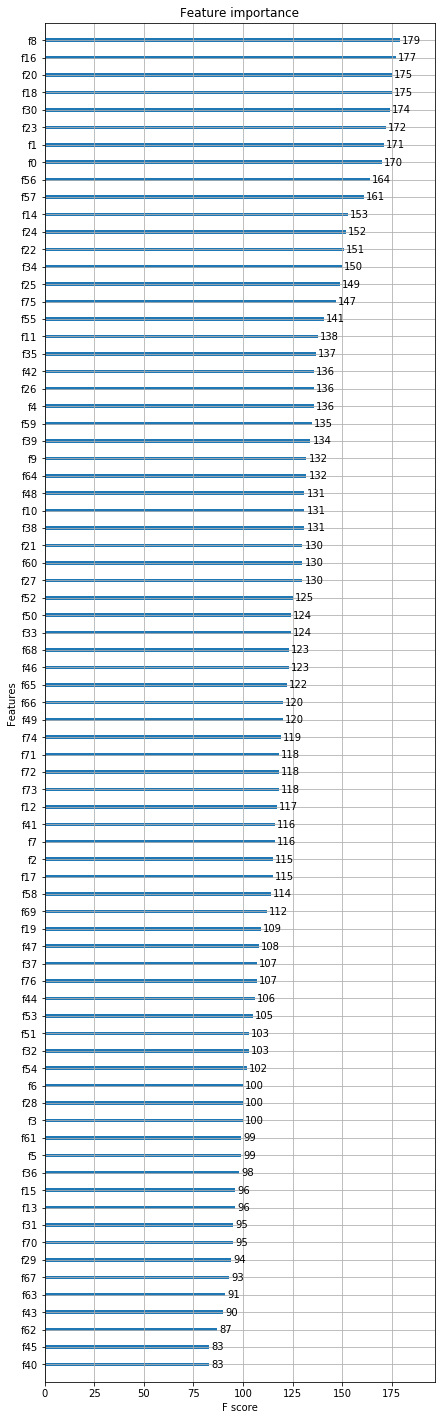

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 25))
plot_importance(predictor, max_num_features = pca.n_components_, ax=ax)
plt.show()

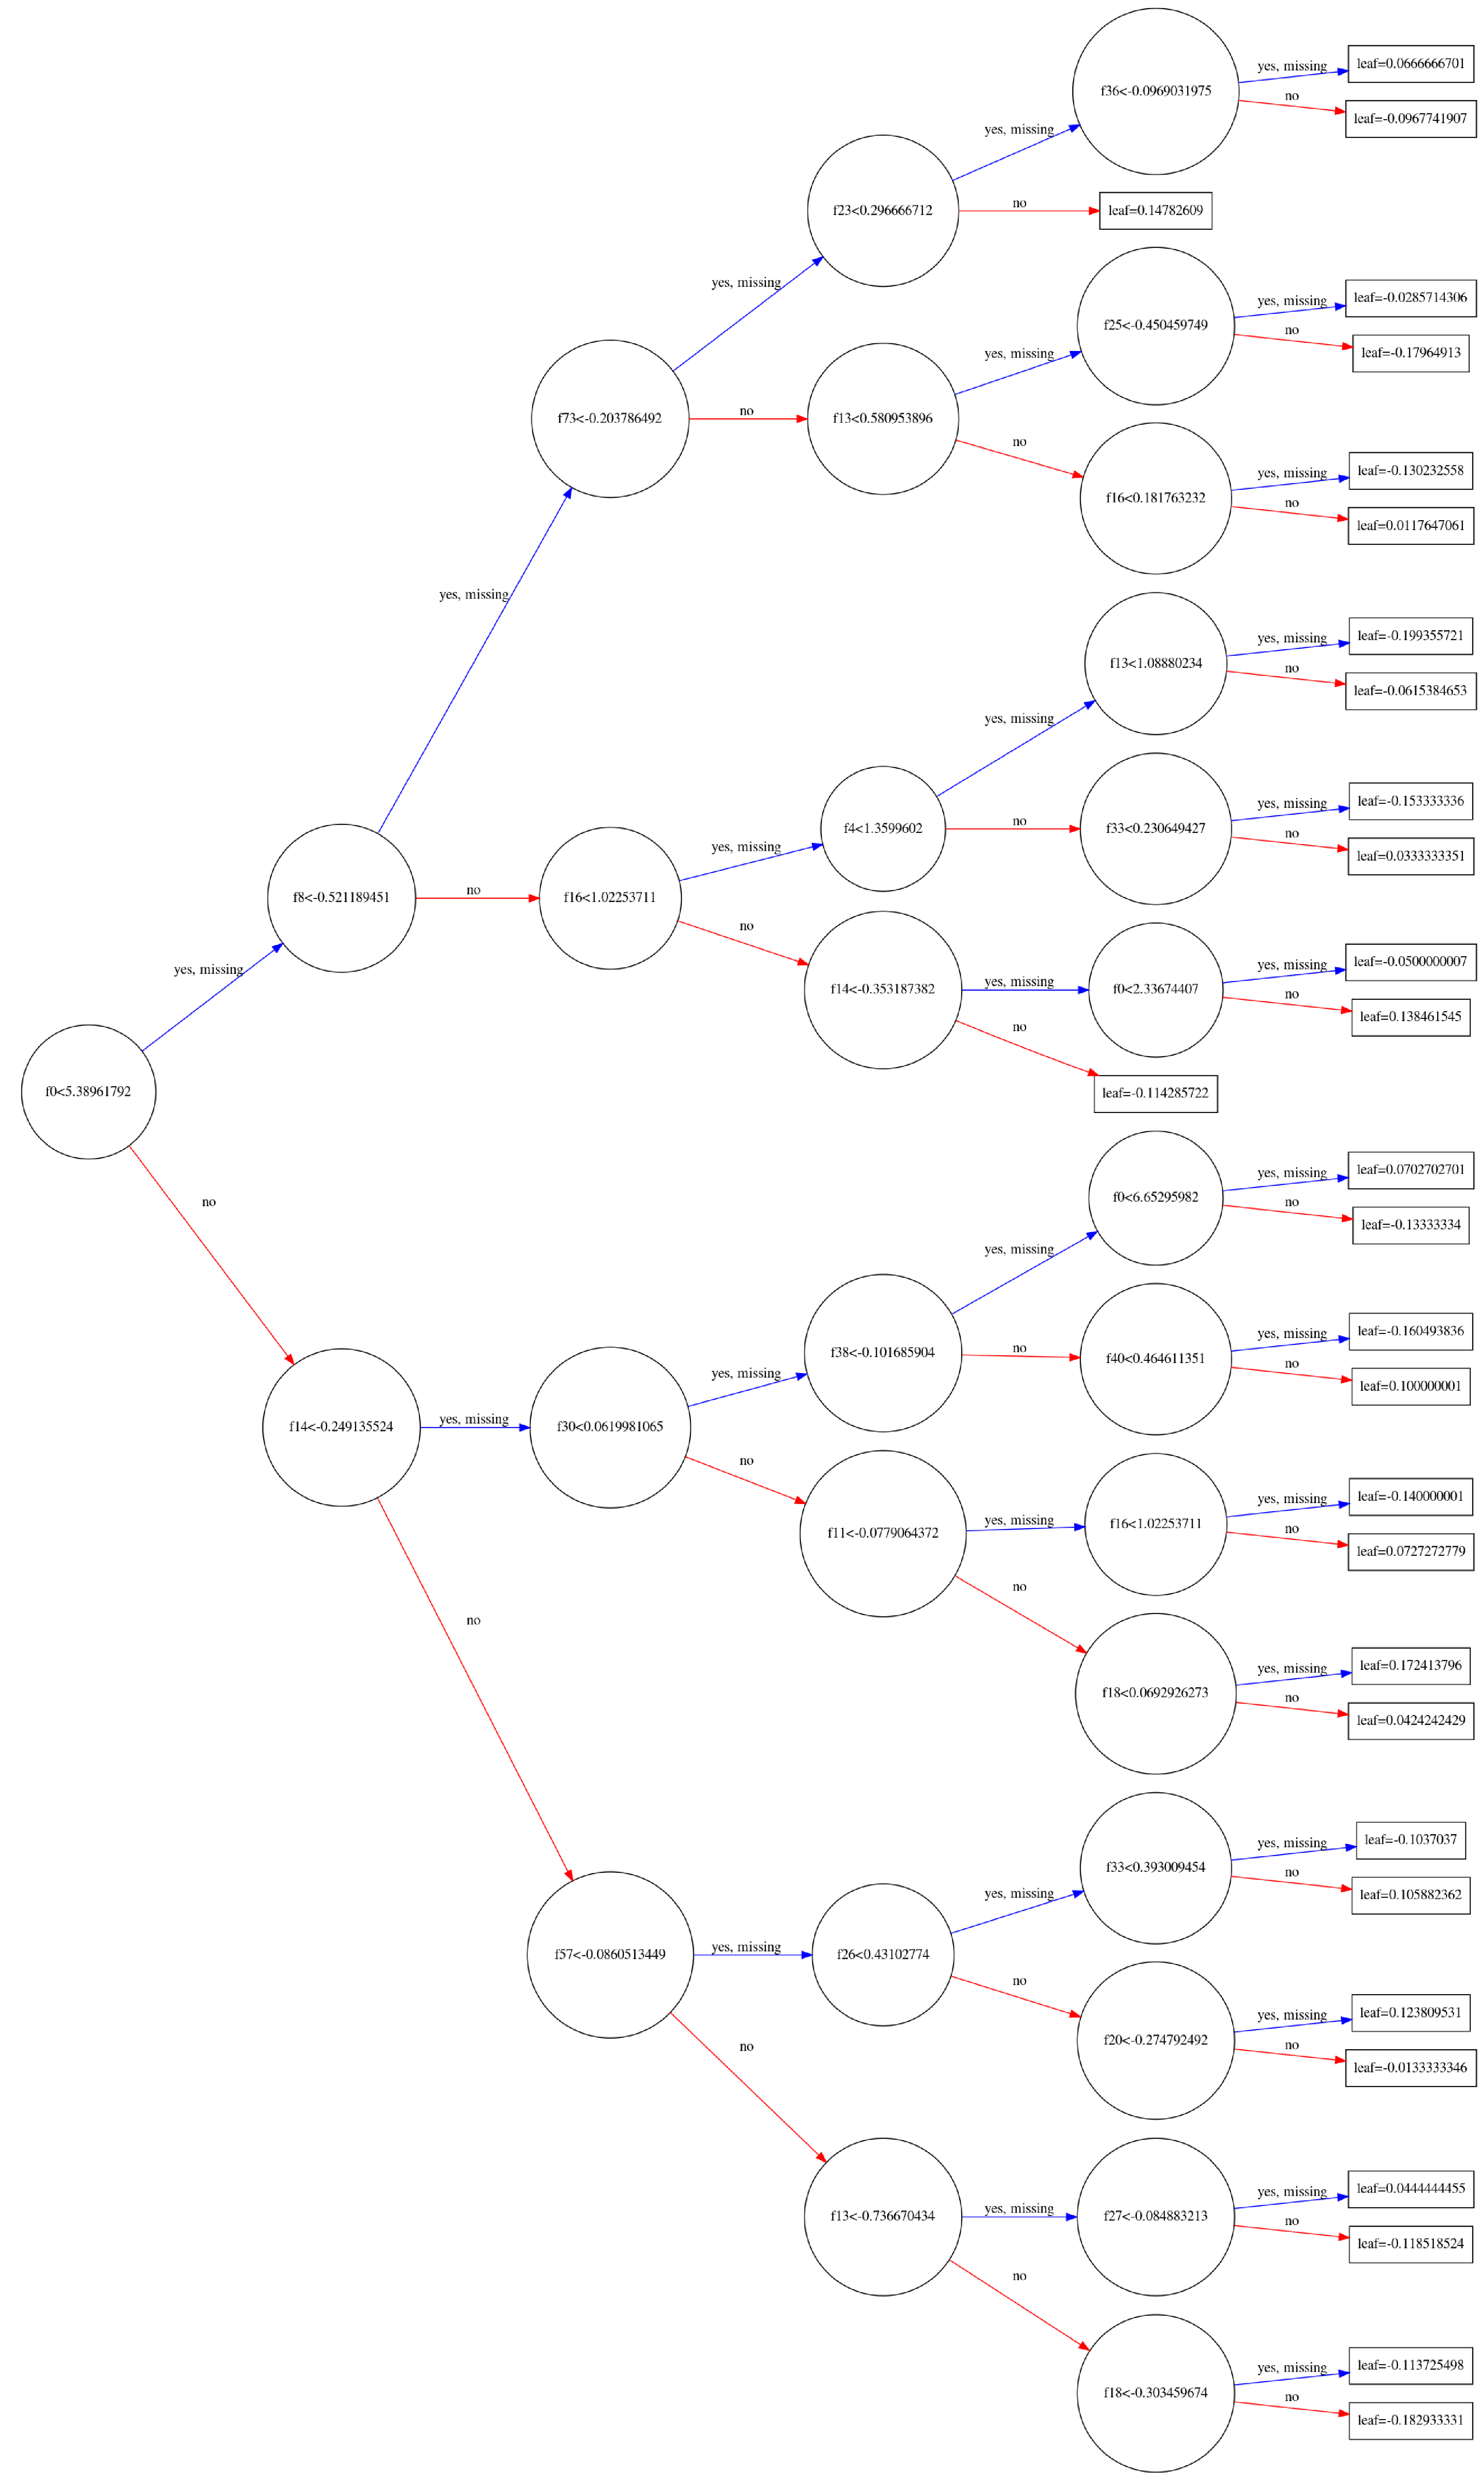

In [ ]:
plot_tree(predictor, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.show()

## Seek hyperparameters

https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier

In [ ]:
%%time

params = {
'max_depth':[4,5,6,7],
'learning_rate':[0.1, 0.15, 0.2],
'gamma':[0.0],
'min_child_weight':[1],
'max_delta_step':[5],
'colsample_bytree':[0.8],
'n_estimators':[300, 500, 700],
'subsample':[0.5],
'objective':['binary:logistic'],
'nthread':[4],
'scale_pos_weight':[1],
'seed':[random_seed],
'verbose': [10]}

model = xgb.XGBClassifier(tree_method='hist')
cv = GridSearchCV(model, params, cv=5, n_jobs=4, scoring='roc_auc')

cv.fit(X_reduced_data, y)
print(cv.best_estimator_)

In [ ]:
predictor = cv.best_estimator_
predictor.save_model('./model/xgb.model')

In [ ]:
print(predictor.score(pca.transform(X_test_given_scaled), y_test_given))
print("Best parameters: %s" % cv.best_params_)
print("Best auroc score: %s" % cv.best_score_)

In [ ]:
score = predictor.predict_proba(X_reduced_data)
print('Best ROC-AUC: {:.4f}'.format(roc_auc_score(y, score[:, 1], average='macro')))

In [ ]:
predict = predictor.predict(X_reduced_test_data)
print("accuracy score : {}".format(accuracy_score(y_test_given, predict)))
print(classification_report( y_true = y_test_given, y_pred = predict ))
confusion_matrix(y_true = y_test_given, y_pred = predict )

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 25))
plot_importance(predictor, max_num_features = pca.n_components_, ax=ax)
plt.show()

In [ ]:
plot_tree(predictor, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.show()

In [ ]:
predictor = xgb.XGBClassifier()
booster = xgb.Booster()
booster.load_model('./model/xgb.model')
predictor._Booster = booster
predictor

## V. Conclusion
_(approx. 1-2 pages)_

### Free-Form Visualization
In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss. Questions to ask yourself when writing this section:
- _Have you visualized a relevant or important quality about the problem, dataset, input data, or results?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_

### Reflection
In this section, you will summarize the entire end-to-end problem solution and discuss one or two particular aspects of the project you found interesting or difficult. You are expected to reflect on the project as a whole to show that you have a firm understanding of the entire process employed in your work. Questions to ask yourself when writing this section:
- _Have you thoroughly summarized the entire process you used for this project?_
- _Were there any interesting aspects of the project?_
- _Were there any difficult aspects of the project?_
- _Does the final model and solution fit your expectations for the problem, and should it be used in a general setting to solve these types of problems?_

### Improvement
In this section, you will need to provide discussion as to how one aspect of the implementation you designed could be improved. As an example, consider ways your implementation can be made more general, and what would need to be modified. You do not need to make this improvement, but the potential solutions resulting from these changes are considered and compared/contrasted to your current solution. Questions to ask yourself when writing this section:
- _Are there further improvements that could be made on the algorithms or techniques you used in this project?_
- _Were there algorithms or techniques you researched that you did not know how to implement, but would consider using if you knew how?_
- _If you used your final solution as the new benchmark, do you think an even better solution exists?_
